# Практическое задание к уроку "Uplift-моделирование"

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

## Задание 1

скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [2]:
campaings = pd.read_csv('./data.csv')
campaings.head(5)

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

             offer  conversion  
0  Buy One Get One           0  
1         No Offer           0  
2  Buy One Get One           0  
3         Discount           0  
4  Buy One Get One           0

## Задание 2

Поле conversion - это целевая переменная, а offer - коммуникация.  
Переименовать поля (conversion -> target, offer -> treatment)  
Привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [3]:
# Переименовать поля (conversion -> target, offer -> treatment) 
campaings.rename(columns={"conversion": "target", "offer": "treatment"}, inplace=True)
campaings.head(3)

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   

         treatment  target  
0  Buy One Get One       0  
1         No Offer       0  
2  Buy One Get One       0

In [4]:
# Привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
if campaings["treatment"].dtype != np.int64:
    campaings["treatment"] = campaings["treatment"].map(lambda x: int(x != "No Offer"))
campaings["treatment"].head(3)

0    1
1    0
2    1
Name: treatment, dtype: int64

In [5]:
features = campaings.drop(columns=["target"])
target = campaings["target"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.33, 
    random_state=RANDOM_STATE
)

## Задание 4 (переставил перед заданием 3 для удобства)

сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

Категориальные признаки заменим на dummy переменные

In [7]:
X_train = pd.get_dummies(X_train, prefix=['zip_code', 'channel'])
X_test = pd.get_dummies(X_test, prefix=['zip_code', 'channel'])
X_train.head(5)

recency  history  used_discount  used_bogo  is_referral  treatment  \
44233       10    29.99              1          0            0          1   
58749        9    60.25              0          1            0          0   
56296        8   292.30              1          1            1          1   
23444        8    49.05              1          0            0          1   
48936       12   324.32              1          0            0          1   

       zip_code_Rural  zip_code_Surburban  zip_code_Urban  \
44233               0                   0               1   
58749               0                   0               1   
56296               0                   0               1   
23444               0                   0               1   
48936               0                   0               1   

       channel_Multichannel  channel_Phone  channel_Web  
44233                     0              0            1  
58749                     0              1            0  
56296                     0              0            1  
23444                     0              1            0  
48936                     0              0            1

In [8]:
campaings['target'].value_counts()

0    54606
1     9394
Name: target, dtype: int64

Явно дисбаланс классов, будем выравнивать

In [9]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = ros.fit_resample(X_test, y_test)

y_resampled.value_counts(), y_test_resampled.value_counts()

(1    36570
 0    36570
 Name: target, dtype: int64,
 1    18036
 0    18036
 Name: target, dtype: int64)

In [10]:
X_train = X_resampled
y_train = y_resampled
X_test = X_resampled
y_test = y_resampled

## Задание 5
 
провести uplift-моделирование 3 способами: 

1. модель с признаком коммуникации (S learner)
2. модель с трансформацией таргета (трансформация классов п. 2. 1) 
3. вариант с двумя независимыми моделями

In [11]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

### 1. Модель с признаком коммуникации

In [12]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(
    X_train.drop(columns=['treatment']), 
    y_train, 
    X_train['treatment']
)

In [13]:
uplift_sm = sm.predict(X_test.drop(columns=['treatment']))
sm_score_at_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], strategy='by_group', k=0.1)
sm_score_at_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], strategy='by_group', k=0.2)
sm_score_at_10, sm_score_at_20

(0.3062395674099855, 0.27582567884124154)

In [14]:
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_at_10)
models_results['uplift@20%'].append(sm_score_at_20)

### 2. модель с трансформацией таргета

In [15]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train.drop(columns=['treatment']), y_train, X_train['treatment'])

uplift_ct = ct.predict(X_test.drop(columns=['treatment']))

ct_score_at_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], strategy='by_group', k=0.1)
ct_score_at_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], strategy='by_group', k=0.2)
ct_score_at_10, ct_score_at_20


<ipython-input-15-bd7e4d9615da>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train.drop(columns=['treatment']), y_train, X_train['treatment'])


(0.35052772550344063, 0.29554260632730506)

In [16]:
models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_at_10)
models_results['uplift@20%'].append(ct_score_at_20)

### 3. две независимые модели

In [17]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train.drop(columns=['treatment']), y_train, X_train['treatment']
)

uplift_tm = tm.predict(X_test)

tm_score_at_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], strategy='by_group', k=0.1)
tm_score_at_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], strategy='by_group', k=0.2)

tm_score_at_10, tm_score_at_20

(0.4621234130117984, 0.3895547962174476)

In [18]:
models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_at_10)
models_results['uplift@20%'].append(tm_score_at_20)

## Задание 6

в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей


In [19]:
pd.DataFrame(models_results)

approach  uplift@10%  uplift@20%
0            SoloModel    0.306240    0.275826
1  ClassTransformation    0.350528    0.295543
2            TwoModels    0.462123    0.389555

## Задание 7

построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

C:\Python39\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Python39\lib\site-packages\causalml\inference\tree\models.py:792: RuntimeWarning: invalid value encountered in longlong_scalars
  y_mean = n1 / ntot
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.973065 to fit

Wall time: 10.1 s


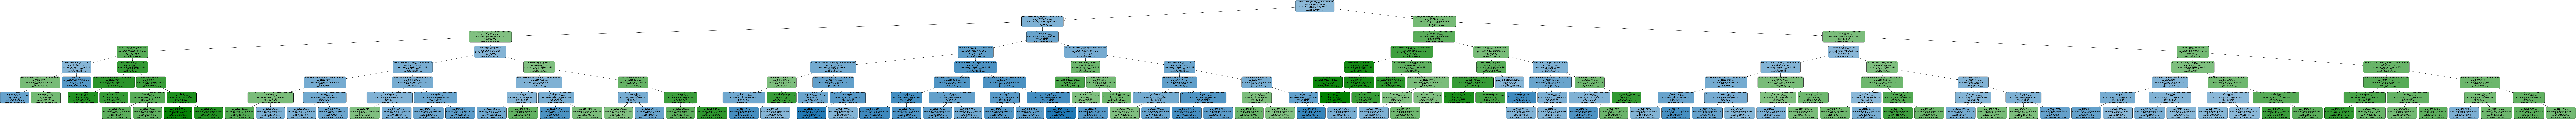

In [20]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=X_train['treatment'].map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

features = X_train.columns

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Ссылки

1. https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
2. https://habr.com/ru/company/ru_mts/blog/485980/#reference1
3. https://en.wikipedia.org/wiki/Uplift_modelling
4. https://www.youtube.com/watch?v=yFQAIJBYXI0
5. https://www.youtube.com/watch?v=jCUcYiBK03I